# Final Sarcasm Detection Model
## With Improved Architecture and Fixes

This notebook trains a sarcasm detection model using the [Universal Sentence Encoder](https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/multilingual-large)

In [2]:
# Import required libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import time

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

c:\Users\vince\.conda\envs\myenv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\vince\.conda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Download and Load Universal Sentence Encoder Model
print("Downloading Universal Sentence Encoder Multilingual...")
path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/multilingual-large")
print("Path to model files:", path)
use_model = hub.load(path)
print("Universal Sentence Encoder loaded successfully!")

Path to model files: C:\Users\vince\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\multilingual-large\2
Universal Sentence Encoder loaded successfully!


In [5]:
# Parameters for the model, adjusted for the new architecture
IMPROVED_PARAMS = {
    'dense1_units': 256,
    'dense2_units': 128,
    'dense_dropout': 0.5,
    'final_dropout': 0.4, 
    'l2_reg': 0.005,      
    'learning_rate': 0.0001,
    'batch_size': 16
}

print("Model parameters set.")

Model parameters set.


### Efficient Model Architecture
The model below uses a Multi-Layer Perceptron (MLP) to classify the sentence embeddings from USE. This is more direct and efficient than the previous LSTM-based approach because USE already provides a single vector representing the entire sentence's meaning. The LSTM layer was not adding value as it was being fed a repeated, static vector.

In [3]:
def create_efficient_model():
    """Create an efficient MLP model with strong regularization"""
    
    # Input layer for the 512-dimensional USE sentence embedding
    input_embeddings = tf.keras.Input(shape=(512,), name='input_embeddings')
    
    # Apply Batch Normalization to the input embeddings
    x = layers.BatchNormalization()(input_embeddings)
    
    # First hidden layer
    x = layers.Dense(
        IMPROVED_PARAMS['dense1_units'], 
        activation='relu', 
        kernel_regularizer=regularizers.l2(IMPROVED_PARAMS['l2_reg'])
    )(x)
    x = layers.Dropout(IMPROVED_PARAMS['dense_dropout'])(x)
    
    # Second hidden layer
    x = layers.Dense(
        IMPROVED_PARAMS['dense2_units'], 
        activation='relu', 
        kernel_regularizer=regularizers.l2(IMPROVED_PARAMS['l2_reg'])
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(IMPROVED_PARAMS['final_dropout'])(x)
    
    # Output layer for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=input_embeddings, outputs=output)
    
    # Compile the model with Adam optimizer, binary cross-entropy loss, and recall as the metric
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=IMPROVED_PARAMS['learning_rate']
        ),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

print("Efficient model creation function defined successfully!")

Efficient model creation function defined successfully!


In [8]:
# Load preprocessed data
print("Loading data...")
df = pd.read_csv('dataset/cleaned_dataset.csv')
df['tweet_processed'] = df['tweet_processed'].fillna('')

texts = df['tweet_processed'].values
labels = df['label'].values

# Perform a stratified train-validation-test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split complete:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Loading data...
Data split complete:
Training set: 17312 samples
Validation set: 2164 samples
Test set: 2165 samples


In [10]:
# Function to create or load embeddings for efficiency
def get_embeddings(texts, file_path, batch_size=32):
    if os.path.exists(file_path):
        print(f"Loading existing embeddings from {file_path}...")
        embeddings = np.load(file_path)
    else:
        print(f"Creating new embeddings for {len(texts)} texts...")
        
        # List to hold embeddings for each batch
        all_embeddings = []
        
        # Process texts in batches
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = use_model(batch_texts).numpy()
            all_embeddings.append(batch_embeddings)
            # Optional: print progress
            print(f"  Processed {i + len(batch_texts)} / {len(texts)}")
            
        # Combine all batch embeddings into a single NumPy array
        embeddings = np.vstack(all_embeddings)
        
        np.save(file_path, embeddings)
        print(f"Embeddings saved to {file_path}")
        
    return embeddings

# --- The rest of your code remains the same ---

embeddings_dir = "embeddings"
os.makedirs(embeddings_dir, exist_ok=True)

# The function calls now work because the batching is handled inside
X_train_embeddings = get_embeddings(X_train, os.path.join(embeddings_dir, "X_train_one_embeddings.npy"))
X_val_embeddings = get_embeddings(X_val, os.path.join(embeddings_dir, "X_val_one_embeddings.npy"))
X_test_embeddings = get_embeddings(X_test, os.path.join(embeddings_dir, "X_test_one_embeddings.npy"))

print(f"\nEmbedding shapes:")
print(f"Train: {X_train_embeddings.shape}")
print(f"Validation: {X_val_embeddings.shape}")
print(f"Test: {X_test_embeddings.shape}")

Loading existing embeddings from embeddings\X_train_one_embeddings.npy...
Loading existing embeddings from embeddings\X_val_one_embeddings.npy...
Loading existing embeddings from embeddings\X_test_one_embeddings.npy...

Embedding shapes:
Train: (17312, 512)
Validation: (2164, 512)
Test: (2165, 512)


In [6]:
# Create the final model
print("Creating final model with the efficient architecture...")
model = create_efficient_model()
model.summary()

Creating final model with the efficient architecture...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embeddings (InputLaye  [(None, 512)]            0         
 r)                                                              
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batc

In [19]:
# Setup callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_recall', patience=10, restore_best_weights=True, verbose=1, mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
    ),
    ModelCheckpoint(
        'mymodels/best_sarcasm_model_efficient.h5', monitor='val_recall', save_best_only=True, verbose=1, mode='max'
    )
]
print("Callbacks configured successfully!")

Callbacks configured successfully!


In [20]:
# Calculate class weights to address the 70/30 imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights calculated: {class_weight_dict}")

Class weights calculated: {0: 0.7778576563623293, 1: 1.3997412677878396}


In [21]:
# Train the final model
print("\n" + "="*60)
print("STARTING FINAL MODEL TRAINING")
print("="*60)

start_time = time.time()

history = model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_val_embeddings, y_val),
    epochs=50,  # Increased epochs as training will be much faster
    batch_size=IMPROVED_PARAMS['batch_size'],
    callbacks=callbacks,
    class_weight=class_weight_dict, # Use class weights
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


STARTING FINAL MODEL TRAINING
Epoch 1/50
1073/1082 [============================>.] - ETA: 0s - loss: 3.2495 - recall: 0.5817
Epoch 1: val_recall improved from -inf to 0.58473, saving model to best_sarcasm_model_efficient.h5
1082/1082 [==============================] - 6s 4ms/step - loss: 3.2478 - recall: 0.5826 - val_loss: 2.8472 - val_recall: 0.5847 - lr: 1.0000e-04
Epoch 2/50
1080/1082 [============================>.] - ETA: 0s - loss: 2.8315 - recall: 0.6398
Epoch 2: val_recall improved from 0.58473 to 0.60543, saving model to best_sarcasm_model_efficient.h5
1082/1082 [==============================] - 5s 4ms/step - loss: 2.8311 - recall: 0.6397 - val_loss: 2.5513 - val_recall: 0.6054 - lr: 1.0000e-04
Epoch 3/50
1076/1082 [============================>.] - ETA: 0s - loss: 2.5200 - recall: 0.6657
Epoch 3: val_recall improved from 0.60543 to 0.65977, saving model to best_sarcasm_model_efficient.h5
1082/1082 [==============================] - 5s 5ms/step - loss: 2.5195 - recall: 0.66

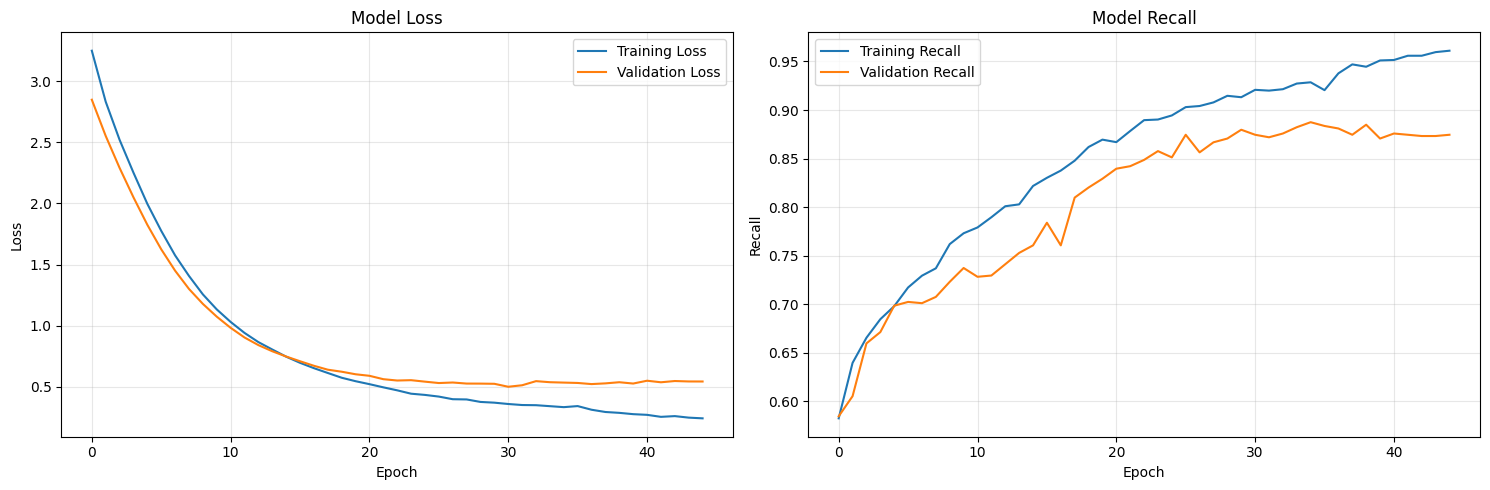

In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss Plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Recall Plot
axes[1].plot(history.history['recall'], label='Training Recall')
axes[1].plot(history.history['val_recall'], label='Validation Recall')
axes[1].set_title('Model Recall')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Recall')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Evaluating model on the test set...
68/68 [==============================] - 1s 2ms/step

Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.94      0.87      0.90      1392
    Sarcastic       0.79      0.90      0.84       773

     accuracy                           0.88      2165
    macro avg       0.87      0.88      0.87      2165
 weighted avg       0.89      0.88      0.88      2165



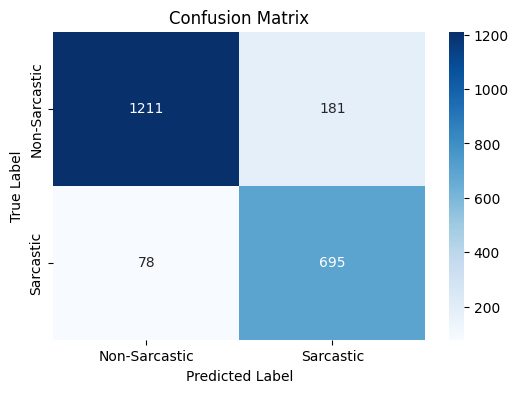

In [11]:
# Evaluate the model on the test set
print("Evaluating model on the test set...")
model.load_weights('mymodels/best_sarcasm_model_efficient.h5') # Restore best weights

y_pred_proba = model.predict(X_test_embeddings)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Sarcastic', 'Sarcastic'],
            yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

### Corrected Prediction Function
This function is now corrected to use the `model` object that was trained in this notebook, making it fully functional for inference on new text.

In [24]:
def predict_sarcasm(text, prediction_model):
    """Function to predict sarcasm for a single text input using a trained model."""
    text = str(text).strip()
    if not text:
        return {"error": "Input text cannot be empty."}
        
    # Get embedding for the input text
    embedding = use_model([text]).numpy()
    
    # Get the model's prediction
    prediction = prediction_model.predict(embedding, verbose=0)
    prob = prediction[0][0]
    
    # Determine label and confidence
    label = "Sarcastic" if prob > 0.5 else "Non-Sarcastic"
    confidence = prob if prob > 0.5 else 1 - prob
    
    return {
        'text': text,
        'prediction': label,
        'probability': float(prob),
        'confidence': float(confidence)
    }

In [26]:
# Indonesian text samples to test
test_texts = [
    # Sarcastic texts (original)
    "Duh, pinter banget sih, sampe nilai ulangannya 0. Gak heran, emang jago bikin masalah.",
    "Wih, gaya loe selangit, tapi dompet kempes. Receh amat.",
    "Bisaan deh, bikin orang kesel. Bener-bener deh, idola banget.",
    "Makan tuh nasihat, abis itu diem deh.",
    "Udah tau salah, masih aja ngeles. Dasar otak udang.",
    "Keren banget sih, kerjaannya cuma rebahan doang.",
    "Hebat ya, bisanya cuma nyuruh-nyuruh orang. Emang situ siapa?",
    "Sok sibuk banget, padahal kerjaannya cuma ngegibah.",
    "Nggak usah sok pinter deh, ngitung duit aja masih salah.",
    "Bagus deh, masalah loe makin banyak. Gak ada capeknya.",
    
    # Non-sarcastic texts (added)
    "Saya sangat terkesan dengan pekerjaan Anda pada proyek ini. Anda telah melakukan pekerjaan yang bagus.",
    "Senang bertemu Anda lagi. Bagaimana kabar Anda?",
    "Saya menghargai bantuan Anda dengan ini. Itu sangat berarti bagi saya.",
    "Cuaca hari ini sangat bagus. Sempurna untuk berjalan-jalan.",
    "Saya turut sedih mendengarnya. Apakah ada yang bisa saya lakukan untuk membantu?",
    "Itu poin yang menarik. Saya belum pernah memikirkannya seperti itu sebelumnya.",
    "Saya menantikan pertemuan kita besok. Seharusnya produktif.",
    "Presentasi Anda sangat informatif. Saya belajar banyak.",
    "Saya senang kita bisa menyelesaikan masalah ini. Mari kita lanjutkan.",
    "Senang memiliki Anda di tim. Keterampilan Anda berharga."
]

print("Sarcasm Detection Results:")
print("=" * 60)

for i, text in enumerate(test_texts, 1):
    # Pass the trained 'model' to the prediction function
    result = predict_sarcasm(text, model)
    print(f"\nText {i}: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Probability: {result['probability']:.3f}")
    print(f"Confidence: {result['confidence']:.3f}")
    print("-" * 50)

Sarcasm Detection Results:

Text 1: Duh, pinter banget sih, sampe nilai ulangannya 0. Gak heran, emang jago bikin masalah.
Prediction: Non-Sarcastic
Probability: 0.136
Confidence: 0.864
--------------------------------------------------

Text 2: Wih, gaya loe selangit, tapi dompet kempes. Receh amat.
Prediction: Sarcastic
Probability: 0.977
Confidence: 0.977
--------------------------------------------------

Text 3: Bisaan deh, bikin orang kesel. Bener-bener deh, idola banget.
Prediction: Sarcastic
Probability: 0.600
Confidence: 0.600
--------------------------------------------------

Text 4: Makan tuh nasihat, abis itu diem deh.
Prediction: Sarcastic
Probability: 0.661
Confidence: 0.661
--------------------------------------------------

Text 5: Udah tau salah, masih aja ngeles. Dasar otak udang.
Prediction: Sarcastic
Probability: 0.893
Confidence: 0.893
--------------------------------------------------

Text 6: Keren banget sih, kerjaannya cuma rebahan doang.
Prediction: Non-Sarca